## Import libraries

In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
import warnings
warnings.filterwarnings('ignore')


## Phase 1: Initial Data Exploration


##### 1-Load data

##### 2-See info

##### 3-Look at the first few rows

##### 4-Basic statistics

In [299]:
df = pd.read_csv('car_data.csv')

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


In [301]:
df.head()

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


In [302]:
df.describe()

,Annual Income,Price ($),Phone
count,2.390600e+04,23906.000000,2.390600e+04
mean,8.308403e+05,28090.247846,7.497741e+06
std,7.200064e+05,14788.687608,8.674920e+05
min,1.008000e+04,1200.000000,6.000101e+06
25%,3.860000e+05,18001.000000,6.746495e+06
50%,7.350000e+05,23000.000000,7.496198e+06
75%,1.175750e+06,34000.000000,8.248146e+06
max,1.120000e+07,85800.000000,8.999579e+06


## Phase 2: Data Quality Issues

##### 1-Handel missing values


In [303]:
df.isnull().sum()


Car_id           0
Date             0
Customer Name    1
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64

In [304]:
print(df.isnull().sum()/df.count())

Car_id           0.000000
Date             0.000000
Customer Name    0.000042
Gender           0.000000
Annual Income    0.000000
Dealer_Name      0.000000
Company          0.000000
Model            0.000000
Engine           0.000000
Transmission     0.000000
Color            0.000000
Price ($)        0.000000
Dealer_No        0.000000
Body Style       0.000000
Phone            0.000000
Dealer_Region    0.000000
dtype: float64


Note: only one null value in Customer Name (lower than 5%  of our data), wont affect our data

In [305]:
df = df.dropna(axis=0, how='any')
df.isnull().sum()

Car_id           0
Date             0
Customer Name    0
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64

##### 2-Handel duplicates

In [306]:
df.duplicated().sum()

np.int64(0)

##### 3-Fix data types

In [307]:
df['Date'] = pd.to_datetime(df['Date'])
df['Phone'].astype('string')

0        8264678
1        6848189
2        7298798
3        6257557
4        7081483
          ...   
23901    8583598
23902    7914229
23903    7659127
23904    6030764
23905    7020564
Name: Phone, Length: 23905, dtype: string

##### 4-Fix typos in Engine column

In [308]:
df['Engine'].value_counts()

Engine
DoubleÂ Overhead Camshaft    12570
Overhead Camshaft            11335
Name: count, dtype: int64

In [309]:
df.replace({'Â ': ' '}, regex=True, inplace=True)

In [310]:
df['Engine'].value_counts()


Engine
Double Overhead Camshaft    12570
Overhead Camshaft           11335
Name: count, dtype: int64

## Phase 3: Outlier Detection & Removal

#### 1-Remove price outliers within groups

After careful examination in the data, I have noticed that the price for the same car (same dealer_region, same color, same model, almost the same income annual for the customer) varies, for example:

1- MiddleTown | Corolla | Pale White | 20000
2- MiddleTown | Corolla | Pale White | 45000

Which means we have price outliers with the same group, so I decided to remove them via IQR

In [311]:
def remove_price_outliers(df):

    grouping_cols = ['Company', 'Model', 'Color', 'Dealer_Region']

    # Calculate IQR for each group
    def flag_outliers(group):
        Q1 = group['Price ($)'].quantile(0.25)
        Q3 = group['Price ($)'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Flag rows with True/False if they are an outlier
        # True -> no outlier || False -> outlier
        group['is_valid'] = (group['Price ($)'] >= lower_bound) & (group['Price ($)'] <= upper_bound)
        return group

    # Apply to each group
    df = df.groupby(grouping_cols, group_keys=False).apply(flag_outliers)

    # Show how many outliers were found
    # The ~ is the "NOT" operator for pandas, using not won't work and will give an error
    print(f"Found {(~df['is_valid']).sum()} outliers out of {len(df)} rows")
    print(f"That's {(~df['is_valid']).sum() / len(df) * 100:.2f}% of data")

    # Keep only valid rows
    df_clean = df[df['is_valid']].drop('is_valid', axis=1).copy()

    return df_clean


df_clean = remove_price_outliers(df)

Found 1825 outliers out of 23905 rows
That's 7.63% of data


In [312]:
df_clean

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,2022-01-02,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Double Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,2022-01-02,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,Double Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,2022-01-02,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,2022-01-02,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,2022-01-02,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,Double Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23901,C_CND_023902,2023-12-31,Martin,Male,13500,C & M Motors Inc,Plymouth,Voyager,Overhead Camshaft,Manual,Red,12000,60504-7114,Passenger,8583598,Pasco
23902,C_CND_023903,2023-12-31,Jimmy,Female,900000,Ryder Truck Rental and Leasing,Chevrolet,Prizm,Double Overhead Camshaft,Auto,Black,16000,06457-3834,Hardtop,7914229,Middletown
23903,C_CND_023904,2023-12-31,Emma,Male,705000,Chrysler of Tri-Cities,BMW,328i,Overhead Camshaft,Manual,Red,21000,99301-3882,Sedan,7659127,Scottsdale
23904,C_CND_023905,2023-12-31,Victoire,Male,13500,Chrysler Plymouth,Chevrolet,Metro,Double Overhead Camshaft,Auto,Black,31000,53546-9427,Passenger,6030764,Austin


#### 2-Check outliers in other numerical columns

Note: Only Annual Income will be checked

In [313]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22080 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Car_id         22080 non-null  object        
 1   Date           22080 non-null  datetime64[ns]
 2   Customer Name  22080 non-null  object        
 3   Gender         22080 non-null  object        
 4   Annual Income  22080 non-null  int64         
 5   Dealer_Name    22080 non-null  object        
 6   Company        22080 non-null  object        
 7   Model          22080 non-null  object        
 8   Engine         22080 non-null  object        
 9   Transmission   22080 non-null  object        
 10  Color          22080 non-null  object        
 11  Price ($)      22080 non-null  int64         
 12  Dealer_No      22080 non-null  object        
 13  Body Style     22080 non-null  object        
 14  Phone          22080 non-null  int64         
 15  Dealer_Region  22080 non

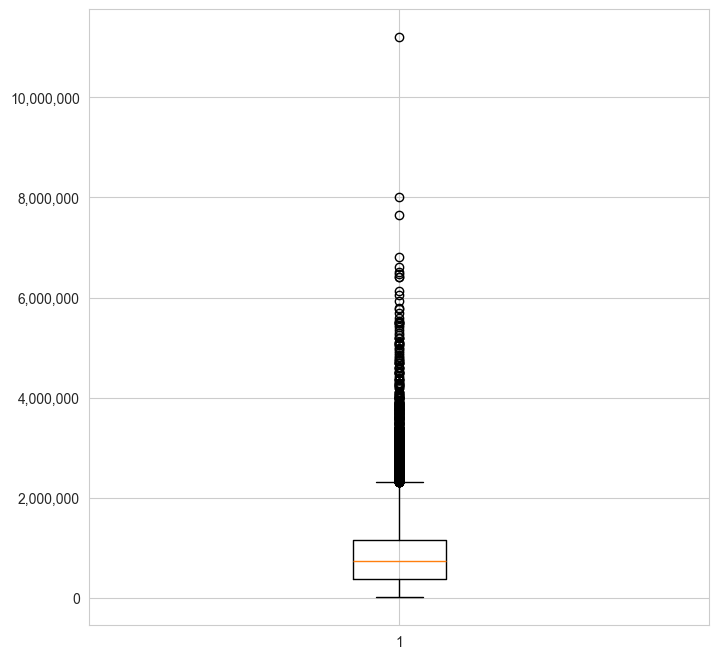

In [314]:
plt.figure(figsize=(8,8))
plt.boxplot(df_clean['Annual Income'])
ax = plt.gca()  # Get current axes
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, p: f'{int(num):,}')) #Just to fix the numbers from having "1e7" to display the bigger picture of that number
plt.show()

In [315]:
print(f"Before: {len(df_clean)}")

Q1 = df_clean['Annual Income'].quantile(0.25)
Q3 = df_clean['Annual Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clean = df_clean[(df_clean['Annual Income'] >= lower_bound) & (df_clean['Annual Income'] <= upper_bound)]

print(f"After: {len(df_clean)}")

Before: 22080
After: 21284


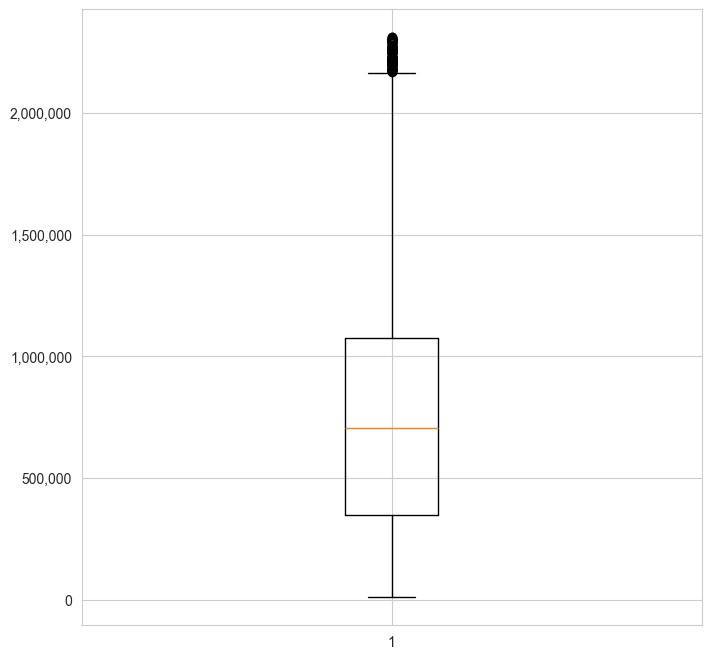

In [316]:
plt.figure(figsize=(8,8))
plt.boxplot(df_clean['Annual Income'])
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda num, p: f'{int(num):,}'))

## Phase 4: Feature Engineering (Before Cleaning)

I have decided to get rid of the company column as it has 30 unique values.

I will replace it with:

1-A country of origin column
ex:
       'Toyota': 'Japanese',
        'Honda': 'Japanese',
         'Nissan': 'Japanese',

2-Make another column to indicate:
Luxury/ Mid-range / Economy

In [317]:
df['Company'].value_counts()

Company
Chevrolet     1819
Dodge         1670
Ford          1614
Volkswagen    1333
Mercedes-B    1285
Mitsubishi    1277
Chrysler      1120
Oldsmobile    1111
Toyota        1110
Nissan         886
Mercury        874
Lexus          802
Pontiac        796
BMW            790
Volvo          789
Honda          708
Acura          689
Cadillac       652
Plymouth       617
Saturn         586
Lincoln        492
Audi           468
Buick          439
Subaru         405
Jeep           363
Porsche        361
Hyundai        264
Saab           210
Infiniti       195
Jaguar         180
Name: count, dtype: int64

Note: Making the map

In [318]:
company_to_country = {
    # USA
    "Chevrolet": "USA",
    "Dodge": "USA",
    "Ford": "USA",
    "Chrysler": "USA",
    "Oldsmobile": "USA",
    "Mercury": "USA",
    "Pontiac": "USA",
    "Cadillac": "USA",
    "Plymouth": "USA",
    "Saturn": "USA",
    "Lincoln": "USA",
    "Buick": "USA",
    "Jeep": "USA",

    # Japan
    "Toyota": "Japan",
    "Nissan": "Japan",
    "Honda": "Japan",
    "Lexus": "Japan",
    "Mitsubishi": "Japan",
    "Acura": "Japan",
    "Subaru": "Japan",
    "Infiniti": "Japan",

    # Germany
    "Volkswagen": "Germany",
    "Mercedes-B": "Germany",
    "BMW": "Germany",
    "Audi": "Germany",
    "Porsche": "Germany",

    # Sweden
    "Volvo": "Sweden",
    "Saab": "Sweden",

    # South Korea
    "Hyundai": "South Korea",

    # United Kingdom
    "Jaguar": "UK"
}


In [319]:
company_to_segment = {
    # Luxury
    "Mercedes-B": "Luxury",
    "Lexus": "Luxury",
    "BMW": "Luxury",
    "Volvo": "Luxury",
    "Acura": "Luxury",
    "Cadillac": "Luxury",
    "Lincoln": "Luxury",
    "Audi": "Luxury",
    "Porsche": "Luxury",
    "Saab": "Luxury",
    "Infiniti": "Luxury",
    "Jaguar": "Luxury",

    # Midrange
    "Dodge": "Midrange",
    "Ford": "Midrange",
    "Volkswagen": "Midrange",
    "Chrysler": "Midrange",
    "Oldsmobile": "Midrange",
    "Mercury": "Midrange",
    "Buick": "Midrange",
    "Subaru": "Midrange",
    "Jeep": "Midrange",

    # Economy
    "Chevrolet": "Economy",
    "Mitsubishi": "Economy",
    "Toyota": "Economy",
    "Nissan": "Economy",
    "Pontiac": "Economy",
    "Honda": "Economy",
    "Plymouth": "Economy",
    "Saturn": "Economy",
    "Hyundai": "Economy"
}


#### Mapping

In [320]:
df_clean['Brand Segment'] = df_clean['Company'].map(company_to_segment)
df_clean['Brand Country'] = df_clean['Company'].map(company_to_country)

#### Visualization for some columns

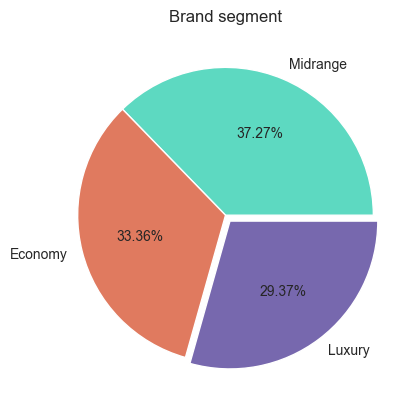

In [321]:
value_brand = df_clean['Brand Segment'].value_counts()
plt.pie(value_brand,
        labels=value_brand.index,
        autopct='%.2f%%',
        explode=(0, 0, 0.05),
        colors=['#5DD9C1', '#E07A5F', '#7768AE'])
plt.title("Brand segment")
plt.show()

Text(0.5, 1.0, 'Transmission')

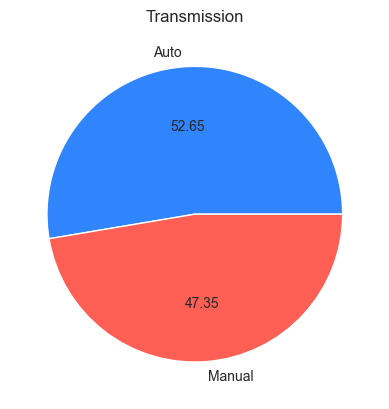

In [322]:
value_trans = df_clean['Transmission'].value_counts()
plt.pie(value_trans,
        labels=value_trans.index,
        autopct='%.2f',
        colors=['#3185FC', '#FE5F55'])
plt.title("Transmission")

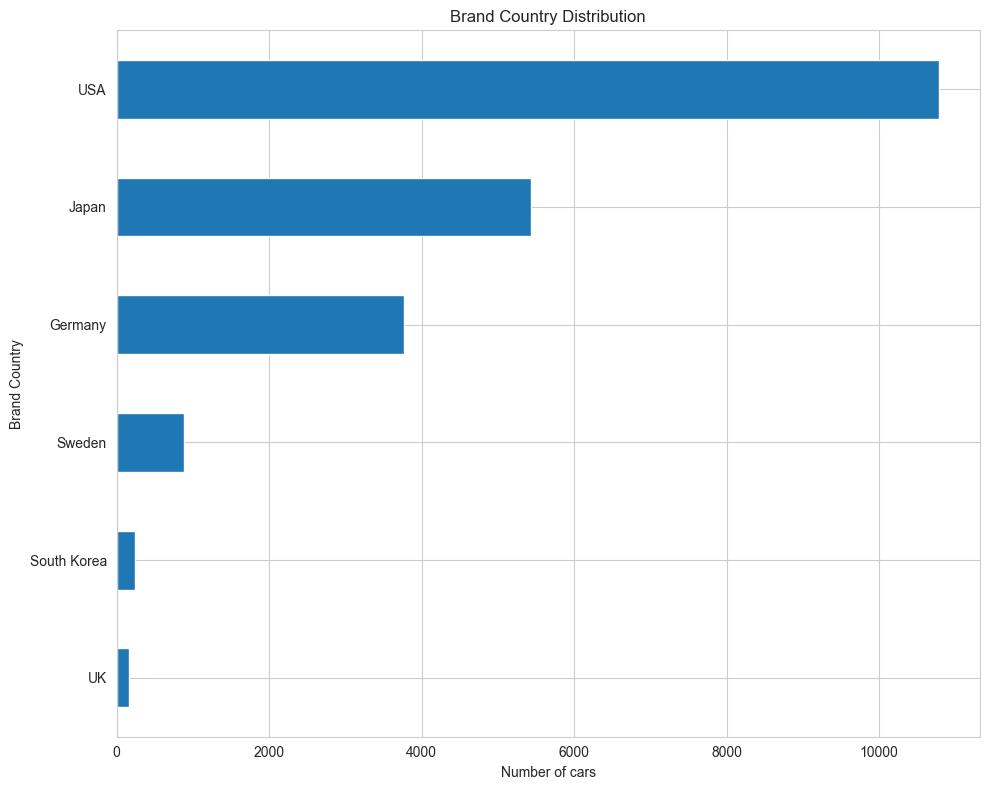

In [323]:
df_clean['Brand Country'].value_counts().plot.barh(figsize=(10,8))
plt.xlabel('Number of cars')
plt.title("Brand Country Distribution")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

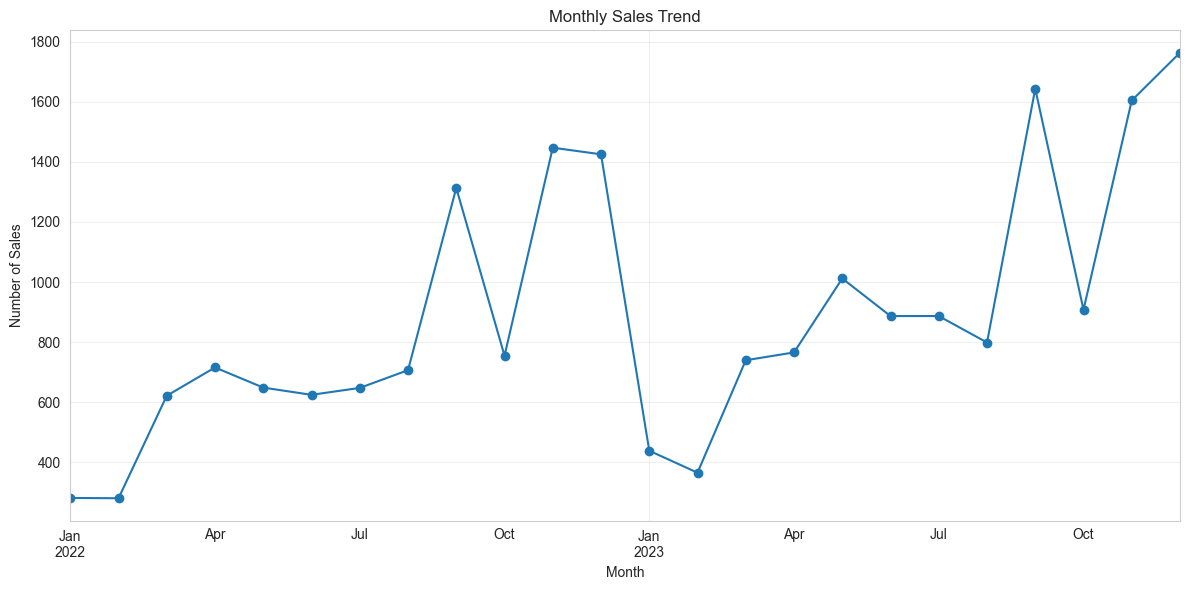

In [324]:
sales_by_month = df_clean.groupby(df_clean['Date'].dt.to_period('M')).size()
plt.figure(figsize=(12,6))
sales_by_month.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.title('Monthly Sales Trend')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Phase 5: Feature Transformation

#### 1-Log transform (fix skewness)

### Before:

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Annual Income'}>],
       [<Axes: title={'center': 'Price ($)'}>,
        <Axes: title={'center': 'Phone'}>]], dtype=object)

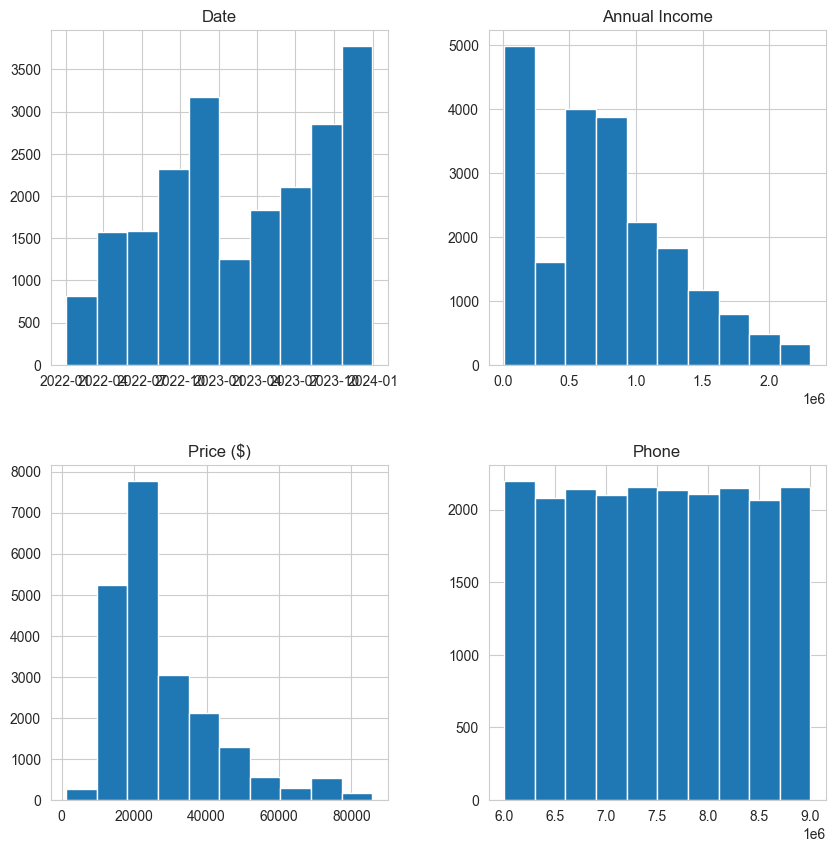

In [325]:
df_clean.hist(figsize=(10,10))

#### Note: Price ($) and Annual Income will be used for the transformation

In [326]:
for col in ['Price ($)', 'Annual Income']:
    df_clean[col] = np.log1p(df_clean[col])

### After:

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Annual Income'}>],
       [<Axes: title={'center': 'Price ($)'}>,
        <Axes: title={'center': 'Phone'}>]], dtype=object)

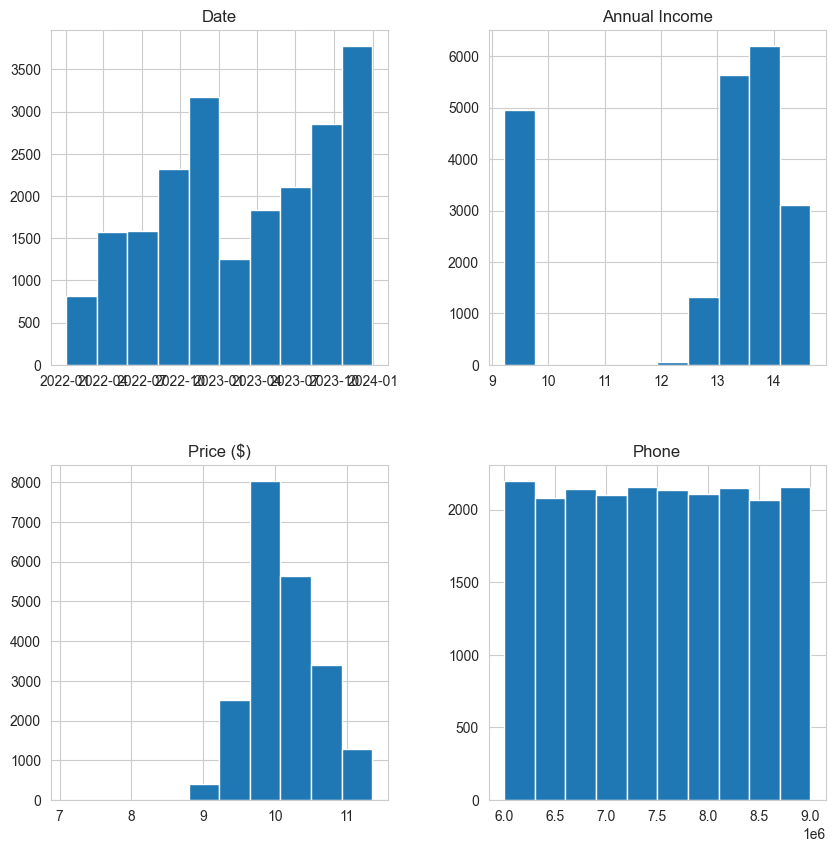

In [327]:
df_clean.hist(figsize=(10,10))

## Phase 6: Train-Test Split

In [328]:
x = df_clean.drop('Price ($)', axis=1)
y = df_clean['Price ($)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Phase 7: Encoding Categorical Variables

In [329]:
x_train.columns

Index(['Car_id', 'Date', 'Customer Name', 'Gender', 'Annual Income',
       'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color',
       'Dealer_No ', 'Body Style', 'Phone', 'Dealer_Region', 'Brand Segment',
       'Brand Country'],
      dtype='object')

In [330]:
for col in ['Model', 'Engine', 'Transmission', 'Color', 'Body Style', 'Dealer_Region', 'Brand Segment', 'Brand Country']:
    print("-----------------------")
    print(x_train[col].value_counts())
    print(f"{col} has {x_train[col].nunique()} categories")

-----------------------
Model
Silhouette       307
Passat           289
LS400            284
Prizm            281
Diamante         272
                ... 
Mirage            16
RX300             15
Alero             14
Avalon            13
Sebring Conv.     10
Name: count, Length: 154, dtype: int64
Model has 154 categories
-----------------------
Engine
Double Overhead Camshaft    8950
Overhead Camshaft           8077
Name: count, dtype: int64
Engine has 2 categories
-----------------------
Transmission
Auto      8950
Manual    8077
Name: count, dtype: int64
Transmission has 2 categories
-----------------------
Color
Pale White    8040
Black         5601
Red           3386
Name: count, dtype: int64
Color has 3 categories
-----------------------
Body Style
SUV          4527
Hatchback    4316
Sedan        3210
Passenger    2844
Hardtop      2130
Name: count, dtype: int64
Body Style has 5 categories
-----------------------
Dealer_Region
Austin        2902
Janesville    2709
Scottsdale    

#### Remake
1-Categories for LabelEncoder:
-Engine
-Transmission
-Brand Segment

2-Categories for OneHotEncoder:
-Color
-Body Style
-Brand Country
-Dealer_Region

3-Category for TargetEncoder:
-Model

#### Note: fit_transform for training data and do not forget transform for testing data

### 1-Label encoder

In [331]:
label_enc = LabelEncoder()

x_train['Engine'] = label_enc.fit_transform(x_train['Engine'])
x_test['Engine'] = label_enc.transform(x_test['Engine'])

x_train['Transmission'] = label_enc.fit_transform(x_train['Transmission'])
x_test['Transmission'] = label_enc.transform(x_test['Transmission'])

x_train['Brand Segment'] = label_enc.fit_transform(x_train['Brand Segment'])
x_test['Brand Segment'] = label_enc.transform(x_test['Brand Segment'])

### 2-One Hot encoder

In [332]:
hot_encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas') #to return a dataframe instead of a numpy array
encoded_color_train = hot_encoder.fit_transform(x_train[['Color']])
encoded_color_test = hot_encoder.transform(x_test[['Color']])

encoded_bodyStyle_train = hot_encoder.fit_transform(x_train[['Body Style']])
encoded_bodyStyle_test = hot_encoder.transform(x_test[['Body Style']])

encoded_brandCountry_train = hot_encoder.fit_transform(x_train[['Brand Country']])
encoded_brandCountry_test = hot_encoder.transform(x_test[['Brand Country']])


encoded_dealerRegion_train = hot_encoder.fit_transform(x_train[['Dealer_Region']])
encoded_dealerRegion_test = hot_encoder.transform(x_test[['Dealer_Region']])

In [333]:
x_train = x_train.drop(['Color', 'Body Style', 'Brand Country', 'Dealer_Region'], axis=1)
x_train = pd.concat([x_train, encoded_color_train, encoded_bodyStyle_train,
                     encoded_brandCountry_train, encoded_dealerRegion_train], axis=1)

x_test = x_test.drop(['Color', 'Body Style', 'Brand Country', 'Dealer_Region'], axis=1)
x_test = pd.concat([x_test, encoded_color_test, encoded_bodyStyle_test,
                    encoded_brandCountry_test, encoded_dealerRegion_test], axis=1)

### 3-Target encoder

Since we have 154 individual models and the model will affect the price, using a one hot encoder will be a waste as it will create 154 columns which is... a lot!

So I found about target encoding.
Target Encoding: replaces each category with a numerical value based on the target(what we will predict) mean value for that category.
It is useful for really high cardinality features and capturing the relationship between each category and the target

Equation for the target encoder behind the scenes:
$$
EncodedValue_i = \frac{n_i \times Mean_i + k \times GlobalMean}{n_i + k}
$$



n: number of rows for category i
Mean: mean of target value for category i
GlobalMean: mean target value for all categories combined (entire dataset)
k: smoothing factor

Smoothing factor:
controls how much to trust the global mean vs the category mean.
Example:

If we have car_model 'A' and car_model 'B' and car_model 'C', with number of rows: 300, 140, 10
and with avg price: 20500, 18000, 50000 respectfully (global mean is 25000)

since we don't have many values for car_model 'C' like car_model 'A' or 'B', the machine learning model will learn that car_model 'C' is expensive which may not be true (because we may not have sold many cars for that car_model for example) and that will cause **"Overfiting"** the model
 In the future if we enter more car data (100 car for example) of that car_model and their price is between 20000-30000, the model will predict 50000 because it "learned" that 50000 is the true value for that car_model so it is wrong and confident

With the smoothing factor, the car_model 'C' mean will be closer to the global mean (25000) so now these rare or small categories don't dominate the model's learning and the predictions are more realistic

Note:
(k: smoothing factor)
-A lot of rows per cat -> k (3-5)
-Some cats have low rows -> k (5-15)
-A lot of rare cats (low num of rows) like 100+ models -> (10-30)
-Very small dataset overall -> k (20- 50)

In [334]:
target_enc = TargetEncoder(cols=['Model'], smoothing=30)

x_train['Model'] = target_enc.fit_transform(x_train['Model'], y_train)
x_test['Model'] = target_enc.transform(x_test['Model'])

## Phase 8: Drop Unnecessary Columns

Note: Make a correlation heatmap to see if any columns have a good relationship to drop one of them

In [335]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17027 entries, 10510 to 17789
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Car_id                     17027 non-null  object        
 1   Date                       17027 non-null  datetime64[ns]
 2   Customer Name              17027 non-null  object        
 3   Gender                     17027 non-null  object        
 4   Annual Income              17027 non-null  float64       
 5   Dealer_Name                17027 non-null  object        
 6   Company                    17027 non-null  object        
 7   Model                      17027 non-null  float64       
 8   Engine                     17027 non-null  int64         
 9   Transmission               17027 non-null  int64         
 10  Dealer_No                  17027 non-null  object        
 11  Phone                      17027 non-null  int64         
 12  Brand

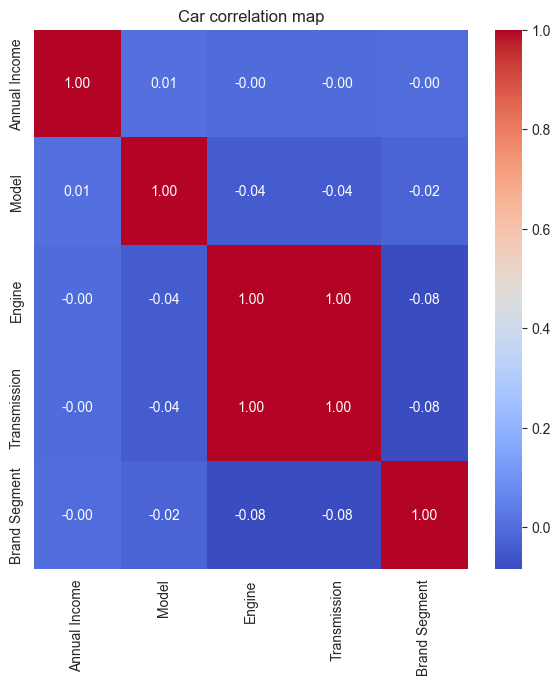

In [336]:
columns = ['Annual Income', 'Model', 'Engine', 'Transmission', 'Brand Segment']

plt.figure(figsize=(7,7))
heatmap = sns.heatmap(x_train[columns].corr(),annot=True, cmap='coolwarm', fmt=".2f", )
heatmap.set_title("Car correlation map")
plt.show()

#### We can see that Transmission and Engine both have a good relationship (1)

In [337]:
x_train

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,...,Brand Country_Sweden,Brand Country_UK,Brand Country_USA,Dealer_Region_Aurora,Dealer_Region_Austin,Dealer_Region_Greenville,Dealer_Region_Janesville,Dealer_Region_Middletown,Dealer_Region_Pasco,Dealer_Region_Scottsdale
10510,C_CND_010511,2022-12-27,Jasper,Female,13.543703,Ryder Truck Rental and Leasing,Pontiac,10.474596,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12549,C_CND_012550,2023-04-07,Charlotte,Male,14.294846,Chrysler of Tri-Cities,Jeep,9.794532,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11249,C_CND_011250,2023-02-05,Vincent,Female,13.554147,New Castle Ford Lincoln Mercury,Lincoln,10.069028,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5780,C_CND_005781,2022-09-17,Raizel,Male,9.510519,Classic Chevy,Dodge,10.326181,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16502,C_CND_016503,2023-08-05,Fradel,Male,13.901689,Rabun Used Car Sales,Volkswagen,9.806400,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12655,C_CND_012656,2023-04-09,Mariam,Male,13.011434,Hatfield Volkswagen,Jeep,9.794532,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13431,C_CND_013432,2023-05-06,Connor,Male,13.208543,Hatfield Volkswagen,Chevrolet,9.894769,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6057,C_CND_006058,2022-09-21,Jadiel,Female,13.253393,Star Enterprises Inc,Toyota,10.604202,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
972,C_CND_000973,2022-03-16,Abdoulaye,Male,9.510519,Scrivener Performance Engineering,Jeep,10.070393,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [338]:
x_train.drop(columns=['Car_id', 'Customer Name', 'Dealer_Name', 'Company', 'Engine', 'Dealer_No ', 'Phone', 'Gender'], inplace=True)

In [339]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17027 entries, 10510 to 17789
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       17027 non-null  datetime64[ns]
 1   Annual Income              17027 non-null  float64       
 2   Model                      17027 non-null  float64       
 3   Transmission               17027 non-null  int64         
 4   Brand Segment              17027 non-null  int64         
 5   Color_Black                17027 non-null  float64       
 6   Color_Pale White           17027 non-null  float64       
 7   Color_Red                  17027 non-null  float64       
 8   Body Style_Hardtop         17027 non-null  float64       
 9   Body Style_Hatchback       17027 non-null  float64       
 10  Body Style_Passenger       17027 non-null  float64       
 11  Body Style_SUV             17027 non-null  float64       
 12  Body 

## Phase 9: Feature Scaling

In [340]:
scaler = StandardScaler()

x_train[['Annual Income']] = scaler.fit_transform(x_train[['Annual Income']])
x_test[['Annual Income']] = scaler.transform(x_test[['Annual Income']])


## Phase 10: Final Validation

In [341]:
x_train.isnull().sum().sum()

np.int64(0)

In [342]:
x_train.shape

(17027, 26)

In [343]:
x_train.duplicated().value_counts()

False    17023
True         4
Name: count, dtype: int64

In [344]:
x_train = x_train.drop_duplicates()
y_train = y_train[x_train.index] #so i dont get a missmatch error cuz the number of rows was decreased in the x_train



In [345]:
x_train.duplicated().sum()

np.int64(0)

## Phase 11: Final Visualization

### Heatmap

Text(0.5, 1.0, 'Car correlation map')

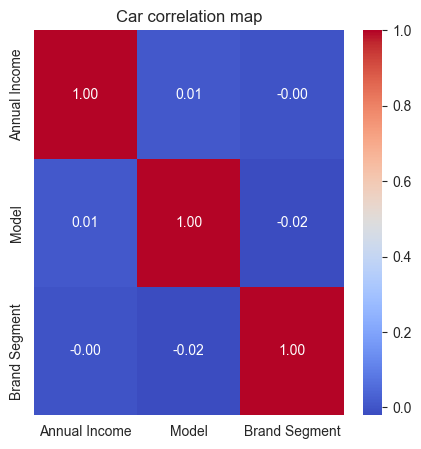

In [346]:
plt.figure(figsize=(5,5))

heatmap = sns.heatmap(x_train[['Annual Income', 'Model', 'Brand Segment']].corr(),
                      annot=True,
                      cmap='coolwarm',
                      fmt=".2f", )

heatmap.set_title("Car correlation map")

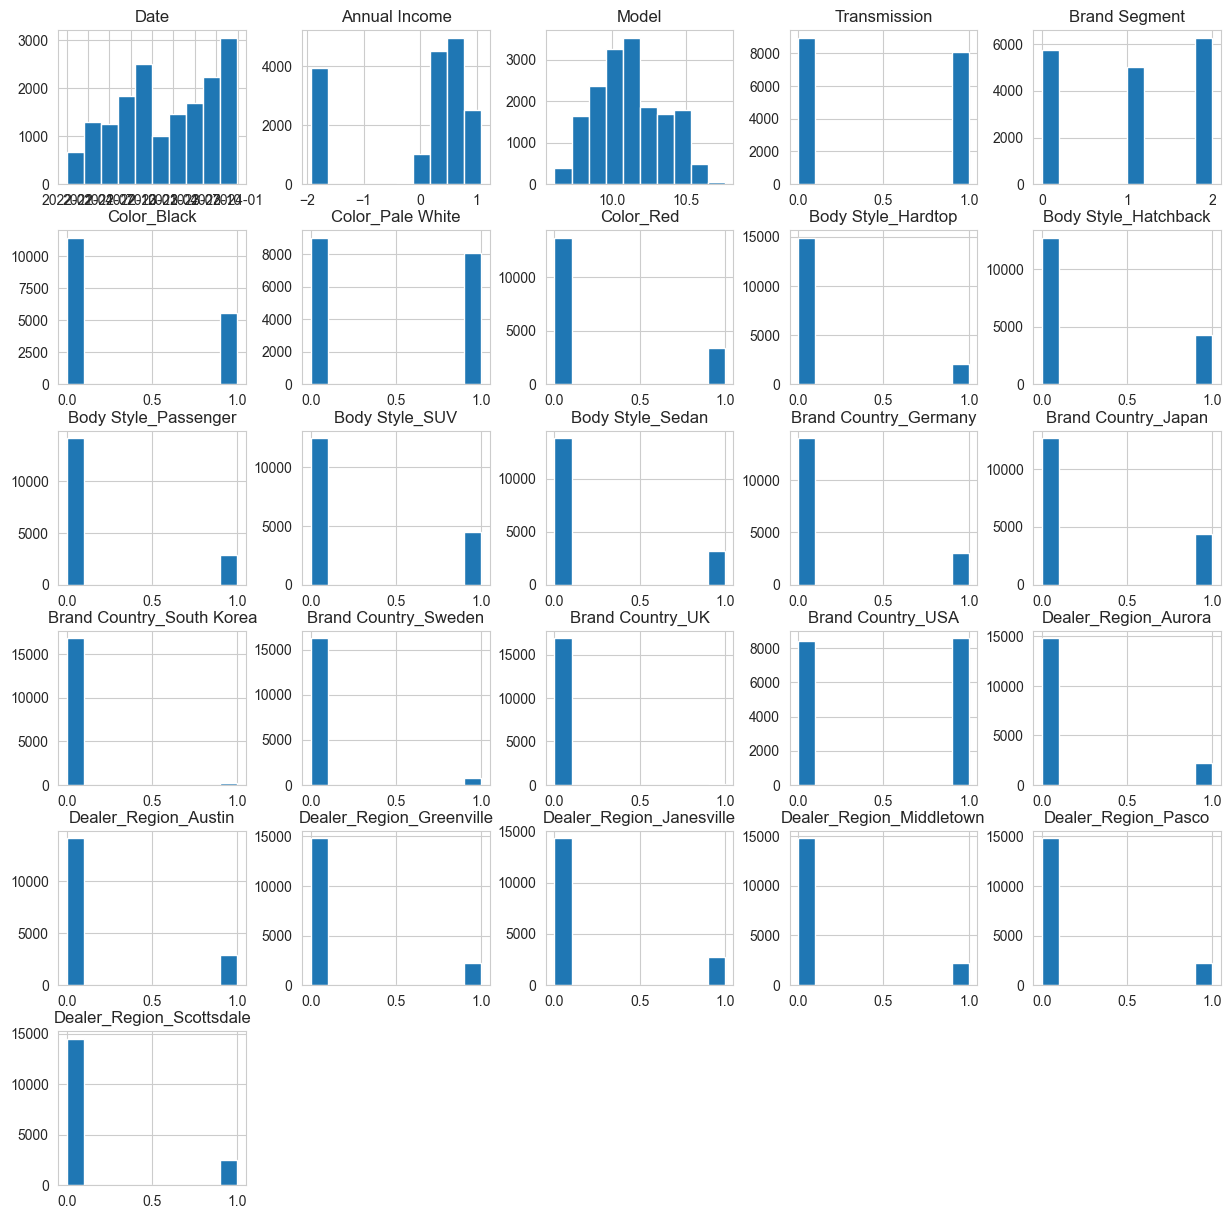

In [347]:
x_train.hist(figsize=(15,15))
plt.show()